Adam Glogovský and Oleksii Bieliaiev

# COVID-19 Outcome Modeling


### All Imports

In [1]:
import warnings
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wandb
from IPython.display import display
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
torch.manual_seed(42)
np.random.seed(42)


Define path to dataset, batch size for training and device (cuda for NVIDIA)

In [ ]:
DATA_PATH = Path("dataset.csv")
BATCH_SIZE = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

#1 if you want to do wandb logs, 0 otherwise
wandb_logs = 0


Device: cuda


Load and explore dataset: show shape, numeric columns, distributions, and correlation heatmap

Shape of dataset: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

,count
USMER,1048575
MEDICAL_UNIT,1048575
SEX,1048575
PATIENT_TYPE,1048575
INTUBED,1048575
PNEUMONIA,1048575
AGE,1048575
PREGNANT,1048575
DIABETES,1048575
COPD,1048575


Dataset shape: (1048575, 21)


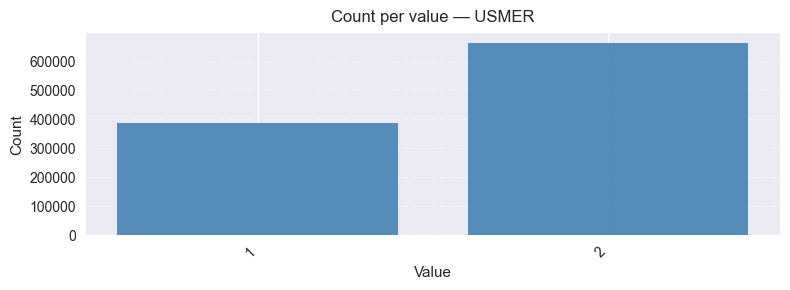

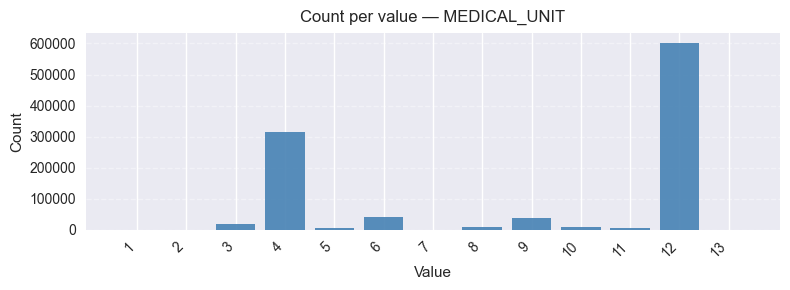

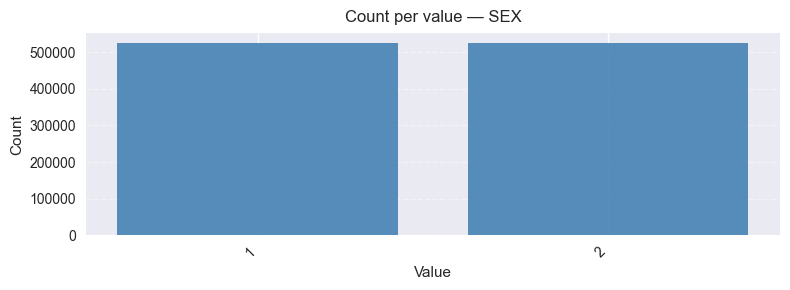

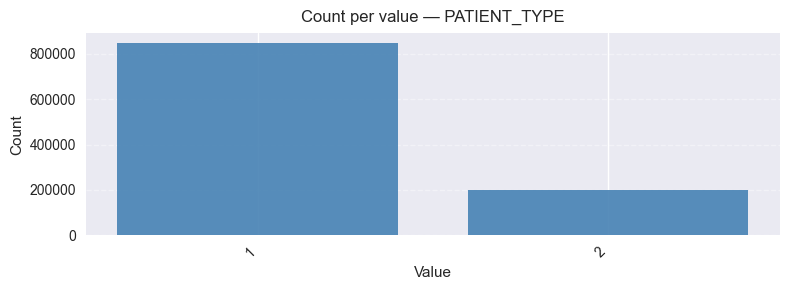

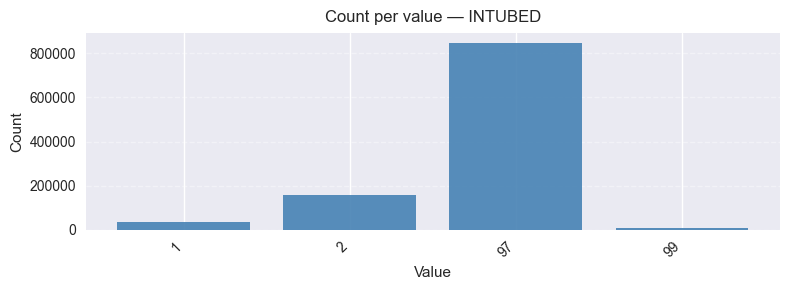

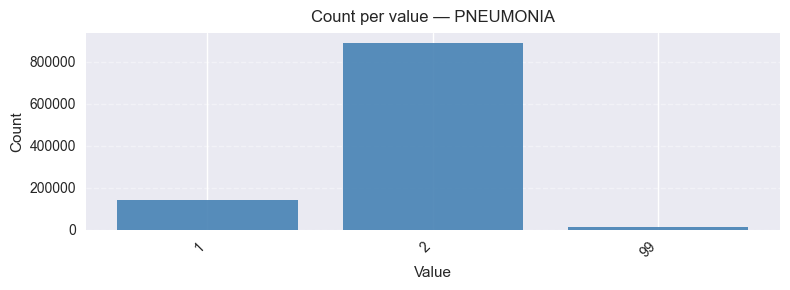

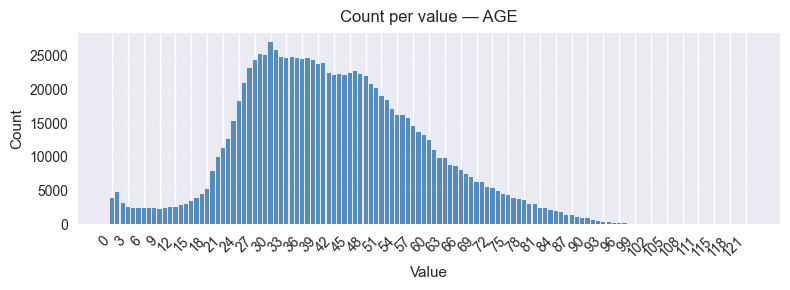

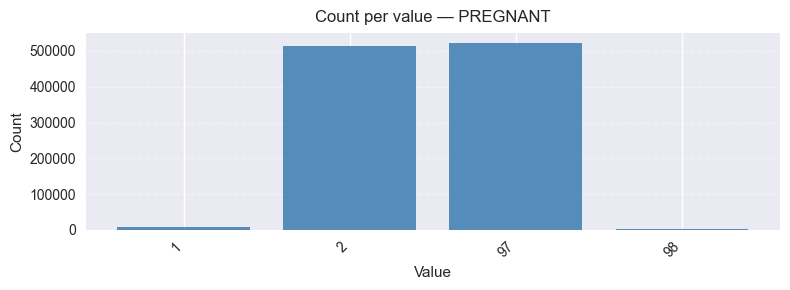

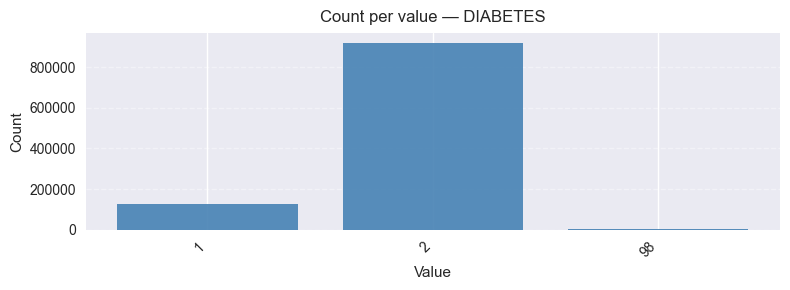

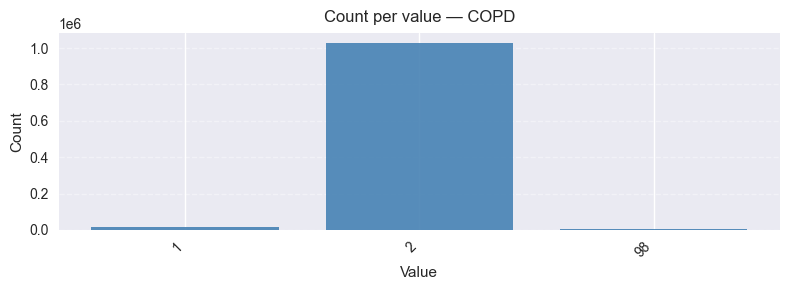

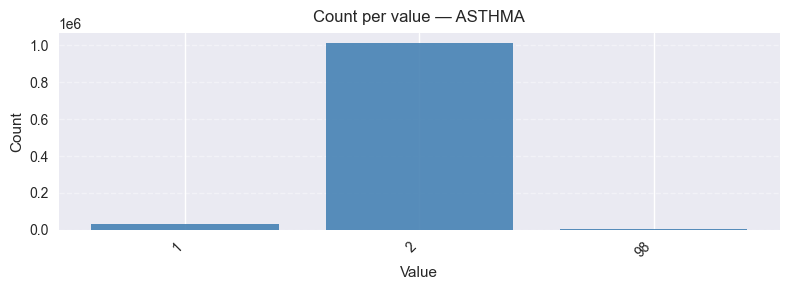

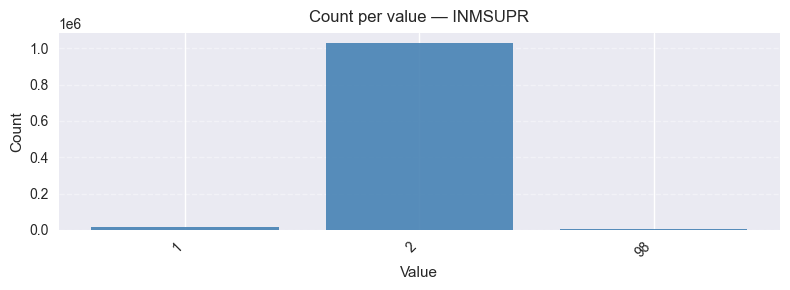

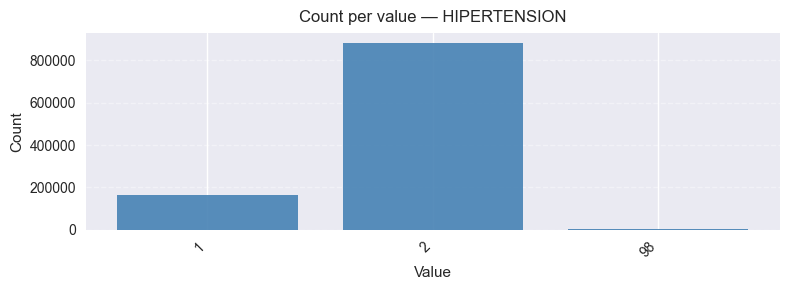

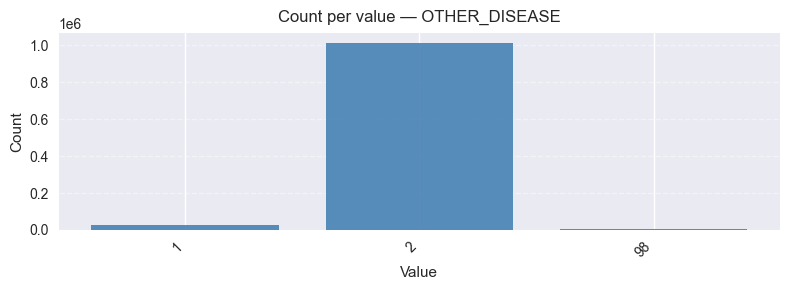

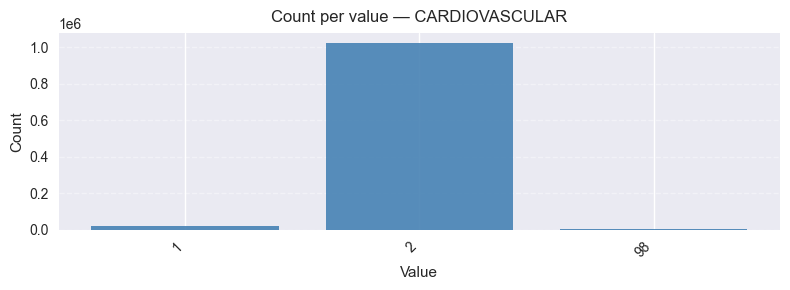

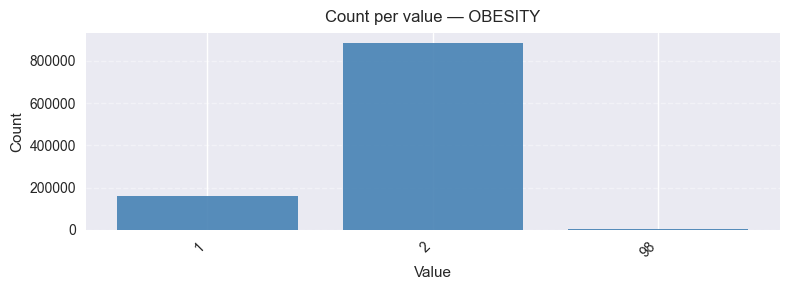

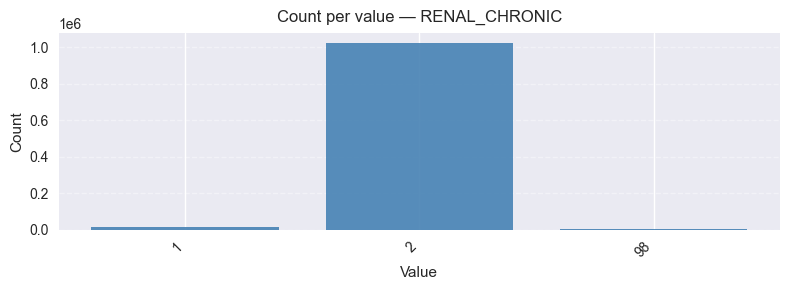

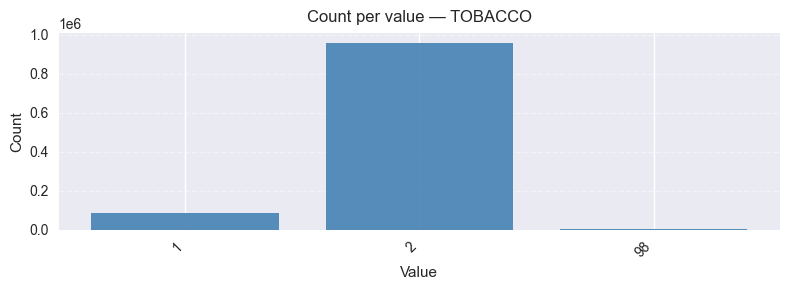

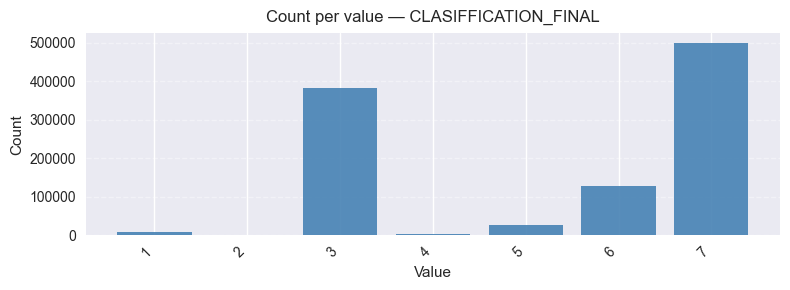

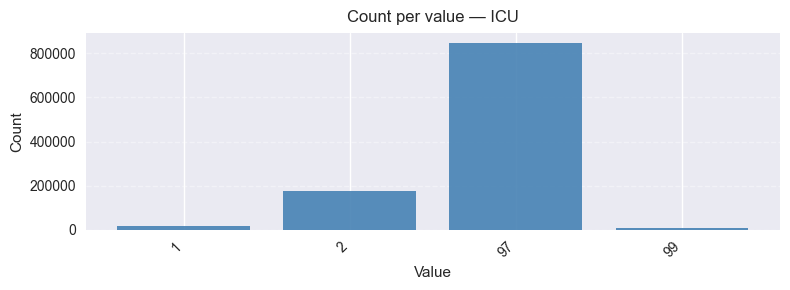

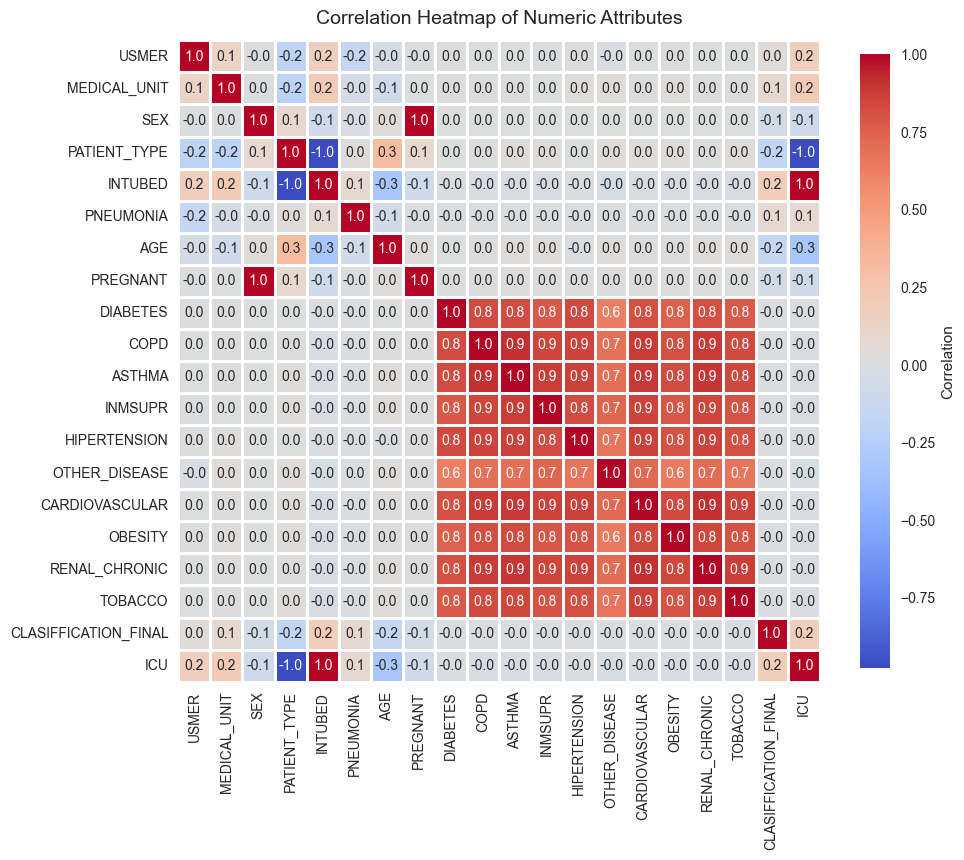

In [3]:
raw_df = pd.read_csv(DATA_PATH)
print(f"Shape of dataset: {raw_df.shape}")
display(raw_df.head())

numeric_df = raw_df.select_dtypes(include=["number"])

raw_df.info()
display(raw_df.count(numeric_only=True).to_frame(name="count"))
print("Dataset shape:", raw_df.shape)

for col in numeric_df.columns:
    series = numeric_df[col]
    counts = series.value_counts(dropna=False).sort_index()
    x = range(len(counts))
    labels = counts.index.astype(str)
    plt.figure(figsize=(8, 3))
    plt.bar(x, counts.values, color="steelblue", alpha=0.9, width=0.8)
    plt.title(f"Count per value — {col}", fontsize=12, pad=8)
    plt.xlabel("Value")
    plt.ylabel("Count")
    if len(labels) > 40:
        step = max(1, len(labels) // 40)
        plt.xticks(list(x)[::step], labels[::step], rotation=45, ha="right")
    else:
        plt.xticks(x, labels, rotation=45, ha="right")
    plt.grid(True, linestyle="--", axis="y", alpha=0.4)
    plt.tight_layout()
    plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".1f",
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)
plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
plt.tight_layout()
plt.show()


## Exploratory analysis


In [4]:
display(raw_df.describe(include='all').transpose())


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
USMER,1048575.0,NaN,NaN,NaN,1.632194,0.482208,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,1048575.0,NaN,NaN,NaN,8.980565,3.723278,1.0,4.0,12.0,12.0,13.0
SEX,1048575.0,NaN,NaN,NaN,1.499259,0.5,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1048575.0,NaN,NaN,NaN,1.190765,0.392904,1.0,1.0,1.0,1.0,2.0
DATE_DIED,1048575,401,9999-99-99,971633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INTUBED,1048575.0,NaN,NaN,NaN,79.522875,36.868886,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,1048575.0,NaN,NaN,NaN,3.346831,11.912881,1.0,2.0,2.0,2.0,99.0
AGE,1048575.0,NaN,NaN,NaN,41.794102,16.907389,0.0,30.0,40.0,53.0,121.0
PREGNANT,1048575.0,NaN,NaN,NaN,49.765585,47.510733,1.0,2.0,97.0,97.0,98.0
DIABETES,1048575.0,NaN,NaN,NaN,2.186404,5.424242,1.0,2.0,2.0,2.0,98.0


Create binary target (1 = COVID, 0 = No COVID) and visualize target and age distributions

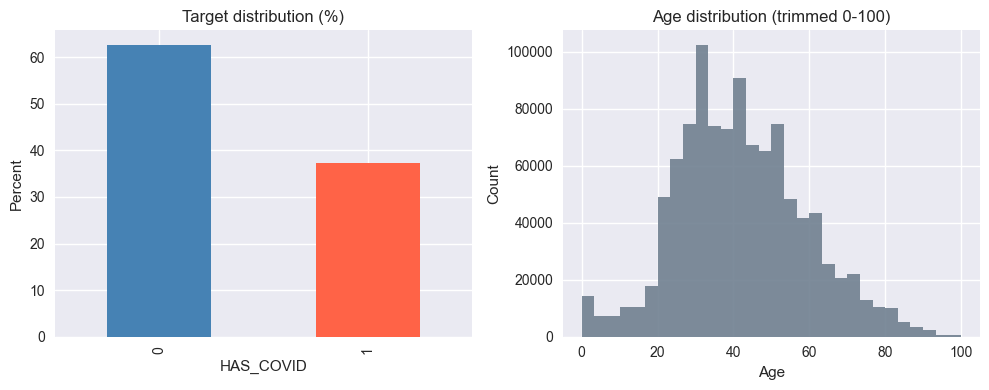

In [5]:
target_series = raw_df['CLASIFFICATION_FINAL'].isin([1, 2, 3]).astype(int)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
target_series.value_counts(normalize=True).mul(100).reindex([0, 1]).plot(
    kind='bar', ax=axes[0], color=['steelblue', 'tomato']
)
axes[0].set_title('Target distribution (%)')
axes[0].set_xlabel('HAS_COVID')
axes[0].set_ylabel('Percent')

age_sample = raw_df['AGE'].clip(0, 100)
axes[1].hist(age_sample, bins=30, color='slategray', alpha=0.9)
axes[1].set_title('Age distribution (trimmed 0-100)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


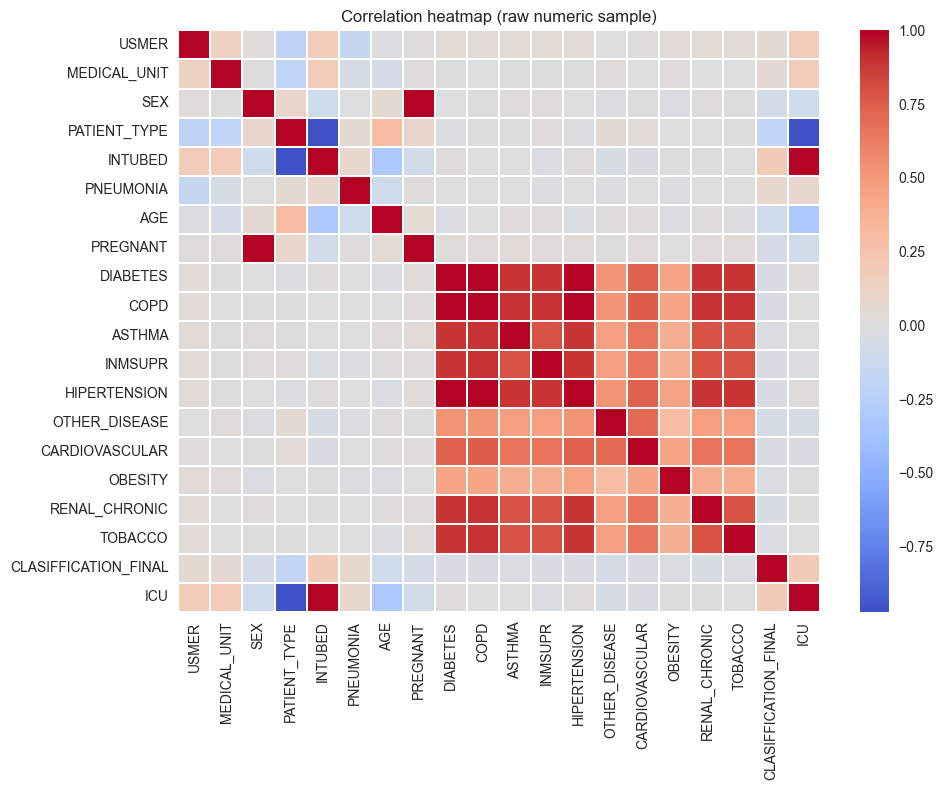

In [6]:
numeric_cols = raw_df.select_dtypes(include=['number']).columns
sample_for_corr = raw_df[numeric_cols].sample(n=min(2000, len(raw_df)), random_state=42)
plt.figure(figsize=(10, 8))
sns.heatmap(sample_for_corr.corr(), cmap='coolwarm', linewidths=0.1, center=0)
plt.title('Correlation heatmap (raw numeric sample)')
plt.tight_layout()
plt.show()


In [7]:
demo_df = raw_df.copy()
print('Sample before preprocessing:')
display(demo_df.iloc[:30])

demo_df.columns = demo_df.columns.str.strip()
demo_df.rename(columns={'DATE_DIED': 'DEAD'}, inplace=True)
med_unit_original = demo_df['MEDICAL_UNIT'].copy()
classif_original = demo_df['CLASIFFICATION_FINAL'].copy()

demo_df['DEAD'] = np.where(demo_df['DEAD'] == '9999-99-99', 2, 1)
demo_df.loc[demo_df['SEX'] == 1, 'PREGNANT'] = 0
binary_cols = ['USMER','SEX','INTUBED','PNEUMONIA','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','ICU','DEAD']
demo_df[binary_cols] = demo_df[binary_cols].replace(2, 0)
demo_df[binary_cols] = demo_df[binary_cols].replace(97, 0.5)
demo_df[binary_cols] = demo_df[binary_cols].replace(98, 0.5)
demo_df['MEDICAL_UNIT'] = med_unit_original
demo_df['CLASIFFICATION_FINAL'] = classif_original
demo_df.rename(columns={'SEX': 'IS_MALE'}, inplace=True)
demo_df['CLASIFFICATION_FINAL'] = demo_df['CLASIFFICATION_FINAL'].replace([1,2,3], 1)
demo_df['CLASIFFICATION_FINAL'] = demo_df['CLASIFFICATION_FINAL'].replace([4,5,6,7], 0)
demo_df.rename(columns={'CLASIFFICATION_FINAL': 'HAS_COVID'}, inplace=True)
print('Sample after key preprocessing steps:')
display(demo_df.iloc[:30])
# Display purpose only


Sample before preprocessing:


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


Sample after key preprocessing steps:


,USMER,MEDICAL_UNIT,IS_MALE,PATIENT_TYPE,DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HAS_COVID,ICU
0,0,1,1,1,1,0.5,1,65,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.5
1,0,1,0,1,1,0.5,1,72,0.5,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0.5
2,0,1,0,2,1,1.0,0,55,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3,0,1,1,1,1,0.5,0,53,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.5
4,0,1,0,1,1,0.5,0,68,0.5,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.5
5,0,1,1,2,0,0.0,1,40,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
6,0,1,1,1,0,0.5,0,64,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5
7,0,1,1,1,0,0.5,1,64,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.5
8,0,1,1,2,0,0.0,0,37,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0
9,0,1,1,2,0,0.0,0,25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


## Preprocessing

Our preprocessing function simply prepares the dataframe we have, for model. We work with only valid values, retype non-numeric values to numeric, normalize data by leaving 1 (true) be 1, but 2 (false) to be 0 and unknown values with np.nan. We ensure that male patients cannot have pregnat value set to 1.
#
Most importanty we replace values in final classification from 1-6 to be only 1 or 2 redefining it to binary classification. (it now represents if the patient is sick, or is not sick). And we also normalize the age of patients

In [8]:
# Preprocessing function that we actually use
def preprocess_data(frame: pd.DataFrame) -> pd.DataFrame:
    df = frame.copy()  # work on a copy to avoid modifying the original dataframe

    # Clean column names and rename gender column for clarity
    df.columns = df.columns.str.strip()
    df.rename(columns={"SEX": "IS_MALE"}, inplace=True)

    # Keep only rows with valid COVID classification values (1–6)
    valid = df["CLASIFFICATION_FINAL"].isin([1, 2, 3, 4, 5, 6])
    df = df.loc[valid].copy()

    # Create binary column DEAD (1 = dead, 0 = alive)
    df["DEAD"] = np.where(df["DATE_DIED"] == "9999-99-99", 0, 1)

    # List of binary features (0/1 type)
    binary_cols = [
        "USMER", "IS_MALE", "INTUBED", "PNEUMONIA", "PREGNANT", "DIABETES", "COPD",
        "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR",
        "OBESITY", "RENAL_CHRONIC", "TOBACCO", "ICU", "DEAD",
    ]

    # Replace invalid codes (97–99 etc.) with NaN to mark missing data
    replace_map = {1: 1, 2: 0, 3: np.nan, 97: np.nan, 98: np.nan, 99: np.nan}
    df[binary_cols] = df[binary_cols].replace(replace_map)

    # Ensure males are never marked as pregnant
    df.loc[df["IS_MALE"] == 1, "PREGNANT"] = 0

    # Create hospitalization flag: 1 = hospitalized, 0 = outpatient
    df["IS_HOSPITALIZED"] = df["PATIENT_TYPE"].map({1: 0, 2: 1}).fillna(0)
    df.drop(columns=["PATIENT_TYPE"], inplace=True)

    # Convert COVID classification (1–3 positive, 4–6 negative) into binary label
    df["HAS_COVID"] = df["CLASIFFICATION_FINAL"].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})
    df.drop(columns=["CLASIFFICATION_FINAL", "DATE_DIED"], inplace=True)

    # Fill missing binary values with median (usually 0 or 1)
    df[binary_cols] = df[binary_cols].fillna(df[binary_cols].median())

    # Define chronic condition columns
    risk_cols = [
        "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION",
        "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC",
    ]

    # Create aggregated health indicators
    df["CHRONIC_COUNT"] = df[risk_cols].sum(axis=1)              # number of chronic diseases
    df["MULTI_MORBID"] = (df["CHRONIC_COUNT"] >= 2).astype(int)  # has 2+ chronic diseases
    df["RISK_OBESE_SMOKER"] = ((df["OBESITY"] == 1) | (df["TOBACCO"] == 1)).astype(int)  # obese or smoker

    # Bucketize age into groups (0–30, 31–45, 46–60, 61–75, 76+)
    df["AGE_BUCKET"] = (
        pd.cut(df["AGE"], bins=[0, 30, 45, 60, 75, 120], labels=False, include_lowest=True)
        .fillna(0)
        .astype(int)
    )

    # Normalize age using standard scaling (mean=0, std=1)
    scaler = StandardScaler()
    df["AGE"] = scaler.fit_transform(df[["AGE"]])

    # One-hot encode medical unit column (convert category → binary columns)
    df = pd.get_dummies(df, columns=["MEDICAL_UNIT"], prefix="MED_UNIT", drop_first=True)

    # Drop any remaining missing values and reset index
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)

    # Return cleaned and fully preprocessed dataset
    return df

In [9]:
model_df = preprocess_data(raw_df)
print(f"Processed shape: {model_df.shape}")
display(model_df.head())
feature_cols = [col for col in model_df.columns if col != "HAS_COVID"]
print(f"Feature count: {len(feature_cols)}")


Processed shape: (549325, 36)


,USMER,IS_MALE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,...,MED_UNIT_4,MED_UNIT_5,MED_UNIT_6,MED_UNIT_7,MED_UNIT_8,MED_UNIT_9,MED_UNIT_10,MED_UNIT_11,MED_UNIT_12,MED_UNIT_13
0,0,1,0.0,1.0,1.262042,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0.0,1.0,1.676426,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,1.0,0.0,0.670064,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0.0,0.0,1.439635,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0,1,0.0,1.0,-0.217902,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


Feature count: 35


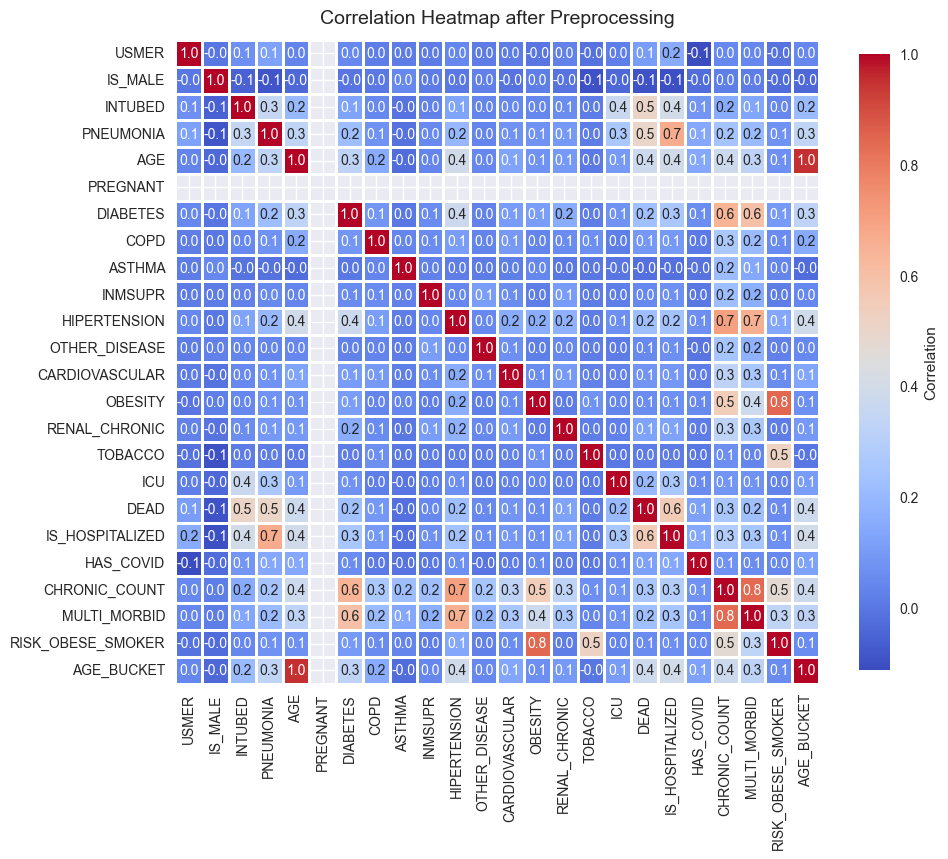

In [10]:
processed_numeric = model_df.select_dtypes(include=['number'])
corr_processed = processed_numeric.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_processed,
    annot=True,
    cmap='coolwarm',
    fmt='.1f',
    square=True,
    linewidths=1,
    cbar_kws={'shrink': 0.7, 'label': 'Correlation'}
)
plt.title('Correlation Heatmap after Preprocessing', fontsize=14, pad=12)
plt.tight_layout()
plt.show()


## Data split
Next we split data for training (70%) for validation (10%) and for testing (20%) so we can accurately train our NN 


In [11]:
# Split dataset into train (70%), validation (10%), and test (20%) sets
train_df, temp_df = train_test_split(
    model_df,
    test_size=0.3,                           # 30% goes to temp (val + test)
    stratify=model_df["HAS_COVID"],          # keep same class ratio across splits
    random_state=42,                         # ensure reproducibility
    shuffle=True,
)

# Split temp into validation (1/3 of temp = 10%) and test (2/3 of temp = 20%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=2 / 3,
    stratify=temp_df["HAS_COVID"],
    random_state=42,
    shuffle=True,
)

# Reset indices for clean dataframes
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Helper function to print class distribution info
def describe_split(name, frame):
    share = frame["HAS_COVID"].mean() * 100
    print(f"{name:<10s} n={len(frame):,} | positive={share:.2f}% | negative={100 - share:.2f}%")

# Display dataset split summary
print("Dataset splits:")
describe_split("Train", train_df)
describe_split("Val", val_df)
describe_split("Test", test_df)

Dataset splits:
Train      n=384,527 | positive=71.36% | negative=28.64%
Val        n=54,932 | positive=71.36% | negative=28.64%
Test       n=109,866 | positive=71.36% | negative=28.64%


## Torch datasets
From now on we will work with PyTorch, so we need to convert our DataFrames to TensorDatasets  


In [12]:
# Convert DataFrame to PyTorch TensorDataset (features + labels)
def frame_to_dataset(frame):
    features = frame[feature_cols].to_numpy(dtype=np.float32)   # input features
    labels = frame["HAS_COVID"].to_numpy(dtype=np.float32)      # target labels
    return TensorDataset(torch.from_numpy(features), torch.from_numpy(labels))

# Create datasets for training, validation, and testing
train_dataset = frame_to_dataset(train_df)
val_dataset = frame_to_dataset(val_df)
test_dataset = frame_to_dataset(test_df)

# Compute class weights to handle imbalance (more weight for minority class)
class_counts = train_df["HAS_COVID"].value_counts().to_dict()
weights = train_df["HAS_COVID"].map(lambda value: 1.0 / class_counts[value]).to_numpy(dtype=np.float32)

# Create a sampler for balanced batches during training
sampler = WeightedRandomSampler(weights=torch.from_numpy(weights), num_samples=len(weights), replacement=True)

# Build data loaders for efficient batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Calculate positive class weight for loss function (to handle imbalance)
positive = float((train_df["HAS_COVID"] == 1).sum())
negative = float((train_df["HAS_COVID"] == 0).sum())
pos_weight_value = negative / max(positive, 1.0)

# Define binary classification loss with class weight
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float32, device=device))

# Inspect one batch from the training loader
sample_batch = next(iter(train_loader))
print(f"Sample batch → X: {sample_batch[0].shape}, y: {sample_batch[1].shape}, pos_weight={pos_weight_value:.2f}")

Sample batch → X: torch.Size([1024, 35]), y: torch.Size([1024]), pos_weight=0.40


## Model and helpers
Using PyTorch integrated linear function, activation function and other cool things, we create our model specialised for binary classification, predicting if the patient has Covid or not.
#
We also calculate metrics like f1 score to determine how good is our NN trained.


In [13]:
# Simple feedforward MLP for binary COVID classification
class CovidMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout):
        super().__init__()
        layers = []
        prev = input_dim  # start with the input feature size

        # build hidden layers based on config
        for hidden in hidden_layers:
            layers.append(nn.Linear(prev, hidden))      # dense layer
            layers.append(nn.BatchNorm1d(hidden))       # helps stabilize training
            layers.append(nn.ReLU())                    # non-linearity
            layers.append(nn.Dropout(dropout))          # regularization
            prev = hidden                               # next layer input = this layer output

        # final output layer (1 neuron for binary classification)
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # forward pass through the network
        return self.net(x).squeeze(1)  # remove extra dimension (batch, 1) → (batch,)


# Calculate common metrics from probabilities
def metrics_from_probs(probs, labels, threshold=0.5):
    preds = (probs >= threshold).astype(int)  # turn probs into 0/1 predictions

    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
        "pr_auc": average_precision_score(labels, probs),  # area under precision-recall curve
    }

    # how much recall we get when precision is at least 0.7
    prec_curve, rec_curve, _ = precision_recall_curve(labels, probs)
    mask = prec_curve >= 0.7
    metrics["recall_at_70_precision"] = float(rec_curve[mask].max()) if mask.any() else 0.0

    return metrics


# Run evaluation on val/test data and collect metrics
def evaluate_model(model, loader):
    model.eval()  # disable dropout, switch to eval mode
    losses, probs, labels = [], [], []

    with torch.no_grad():  # no gradients needed for evaluation
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)             # forward pass
            loss = criterion(logits, yb)   # compute loss
            losses.append(loss.item())

            # convert logits → probabilities and collect labels
            probs.append(torch.sigmoid(logits).cpu())
            labels.append(yb.cpu())

    # merge all batches into full arrays
    prob_array = torch.cat(probs).numpy()
    label_array = torch.cat(labels).numpy()

    # compute metrics
    metrics = metrics_from_probs(prob_array, label_array)
    metrics["roc_auc"] = roc_auc_score(label_array, prob_array)
    metrics["loss"] = float(np.mean(losses))  # average val loss

    return metrics, prob_array, label_array


# Find the threshold that gives the best F1 score
def find_best_threshold(probs, labels):
    best_thr = 0.5
    best_score = 0.0

    # try thresholds from 0.1 to 0.9
    for thr in np.linspace(0.1, 0.9, 17):
        score = f1_score(labels, (probs >= thr).astype(int), zero_division=0)
        if score > best_score:
            best_score = score
            best_thr = float(thr)

    return best_thr, best_score

Our model training function builds the model from the config, initializes the optimizer, scheduler, and logs everything using Wandb.
#
Then it runs set amount of epochs from config, training the model, changing the learning rate and logging more data, and saving the best result for later

In [ ]:
def train_model(config):
    # Build model from config and move to device
    model = CovidMLP(len(feature_cols), config["hidden_layers"], config["dropout"]).to(device)

    # Optimizer: AdamW (Adam + decoupled weight decay for better generalization)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    # LR scheduler: reduce LR when validation loss plateaus (mode='min')
    # factor=0.5 → halve LR; patience=1 → wait 1 epoch without improvement
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=1
    )

    # Initialize Weights & Biases run for experiment tracking
    # - project: group runs
    # - config: hyperparams logged as run config
    # - reinit=False: reuse the same process/run context
    if wandb_logs:
        wandb_run = wandb.init(project="covid-19", config=config, reinit=False)
        wandb_run.watch(model, log="all")  # log gradients/weights for debugging

    best_state = None            # best model weights (by val F1)
    best_snapshot = None         # (metrics, probs, labels) for best epoch
    best_score = -np.inf         # track best F1
    history = []                 # per-epoch metrics for plotting

    # ---- Training loop ----
    for epoch in range(1, config["epochs"] + 1):
        model.train()            # enable dropout/batchnorm updates
        epoch_losses = []

        # Iterate mini-batches
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()                # reset accumulated grads
            logits = model(xb)                   # forward pass → logits
            loss = criterion(logits, yb)         # BCEWithLogitsLoss (with pos_weight)
            loss.backward()                      # backpropagate gradients
            optimizer.step()                     # update weights

            epoch_losses.append(loss.item())

        # ---- Validation ----
        val_metrics, val_probs, val_labels = evaluate_model(model, val_loader)

        # Step LR scheduler with validation loss (expects a scalar)
        scheduler.step(val_metrics["loss"])

        # Save epoch summary for later analysis/plots
        history.append({
            "epoch": epoch,
            "train_loss": float(np.mean(epoch_losses)),
            **{k: v for k, v in val_metrics.items()},
        })

        # Console log
        print(
            f"{config['name']:<10s} epoch {epoch:02d} "
            f"train_loss={history[-1]['train_loss']:.3f} "
            f"val_loss={val_metrics['loss']:.3f} "
            f"val_f1={val_metrics['f1']:.3f}"
        )

        # Log key metrics to W&B for dashboards/curves
        if wandb_logs:
            wandb_run.log({
                "epoch": epoch,
                "train_loss": float(np.mean(epoch_losses)),
                "val_loss": val_metrics["loss"],
                "val_f1": val_metrics["f1"],
                "learning_rate": optimizer.param_groups[0]["lr"],
            })

        # Track best model by validation F1
        if val_metrics["f1"] > best_score:
            best_score = val_metrics["f1"]
            best_state = deepcopy(model.state_dict())                  # keep weights
            best_snapshot = (val_metrics.copy(), val_probs.copy(),     # keep artifacts
                             val_labels.copy())

    # Restore best weights before returning
    model.load_state_dict(best_state)

    # Close W&B run cleanly
    if wandb_logs:
        wandb_run.finish()  

    # Return trained (best) model, full training history, and best-epoch snapshot
    return model, history, best_snapshot

## Experiments
We define a few experiments, with different names so we can track them later. Each of these experiments is a config for our model training function, after each training we save the results of the experiment so we can compare them later.


In [15]:
# Define a small grid of experiments (architectures + hyperparameters)
experiment_grid = [
    {"name": "baseline", "hidden_layers": [128, 64, 32], "dropout": 0.3, "lr": 3e-4, "weight_decay": 1e-4, "epochs": 10},
    {"name": "compact",  "hidden_layers": [64, 32],       "dropout": 0.25, "lr": 5e-4, "weight_decay": 5e-5, "epochs": 12},
    {"name": "wide",     "hidden_layers": [256, 128, 64], "dropout": 0.4,  "lr": 2e-4, "weight_decay": 1e-4, "epochs": 12},
]

experiment_results = []  # will store trained model snapshots + metrics for each config

# Run training for each config in the grid
for cfg in experiment_grid:
    model, history, snapshot = train_model(cfg)  # train and return best-epoch snapshot
    metrics_at_05, val_probs, val_labels = snapshot  # metrics at 0.5 threshold + raw probs/labels

    # Tune decision threshold to maximize F1 on validation set
    best_thr, _ = find_best_threshold(val_probs, val_labels)

    # Recompute metrics using the tuned threshold (keep ROC AUC & loss from snapshot)
    tuned_metrics = metrics_from_probs(val_probs, val_labels, threshold=best_thr)
    tuned_metrics["roc_auc"] = metrics_at_05["roc_auc"]
    tuned_metrics["loss"] = metrics_at_05["loss"]

    # Save experiment artifacts for later comparison / model selection
    experiment_results.append(
        {
            "name": cfg["name"],                     # experiment label
            "config": cfg,                           # full hyperparameter config
            "state_dict": deepcopy(model.state_dict()),  # best model weights
            "threshold": best_thr,                   # tuned decision threshold
            "val_metrics": tuned_metrics,            # metrics at tuned threshold
            "history": history,                      # per-epoch training/val history
        }
    )

# Build a compact comparison table across experiments
results_table = pd.DataFrame(
    [
        {
            "experiment": result["name"],
            "val_f1": result["val_metrics"]["f1"],
            "val_pr_auc": result["val_metrics"]["pr_auc"],
            "val_recall_at_70_precision": result["val_metrics"]["recall_at_70_precision"],
            "threshold": result["threshold"],
        }
        for result in experiment_results
    ]
).sort_values(by="val_f1", ascending=False)  # rank by F1

print("Validation summary:")
display(results_table.reset_index(drop=True))

wandb: Currently logged in as: adamglog9919 (adamglog9919-my_org_ig) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


baseline   epoch 01 train_loss=0.447 val_loss=0.389 val_f1=0.367
baseline   epoch 02 train_loss=0.395 val_loss=0.403 val_f1=0.266
baseline   epoch 03 train_loss=0.390 val_loss=0.406 val_f1=0.261
baseline   epoch 04 train_loss=0.389 val_loss=0.408 val_f1=0.254
baseline   epoch 05 train_loss=0.388 val_loss=0.406 val_f1=0.255
baseline   epoch 06 train_loss=0.387 val_loss=0.406 val_f1=0.260
baseline   epoch 07 train_loss=0.388 val_loss=0.409 val_f1=0.243
baseline   epoch 08 train_loss=0.387 val_loss=0.407 val_f1=0.251
baseline   epoch 09 train_loss=0.387 val_loss=0.407 val_f1=0.247
baseline   epoch 10 train_loss=0.387 val_loss=0.407 val_f1=0.247


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,██▄▄▂▂▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_f1,█▂▂▂▂▂▁▁▁▁
val_loss,▁▆▇█▇▇█▇▇▇
epoch,10
learning_rate,2e-05
train_loss,0.3874
val_f1,0.24728
val_loss,0.40676


compact    epoch 01 train_loss=0.403 val_loss=0.402 val_f1=0.253
compact    epoch 02 train_loss=0.389 val_loss=0.402 val_f1=0.243
compact    epoch 03 train_loss=0.387 val_loss=0.404 val_f1=0.245
compact    epoch 04 train_loss=0.386 val_loss=0.403 val_f1=0.253
compact    epoch 05 train_loss=0.385 val_loss=0.404 val_f1=0.249
compact    epoch 06 train_loss=0.385 val_loss=0.402 val_f1=0.247
compact    epoch 07 train_loss=0.385 val_loss=0.403 val_f1=0.243
compact    epoch 08 train_loss=0.385 val_loss=0.402 val_f1=0.245
compact    epoch 09 train_loss=0.385 val_loss=0.403 val_f1=0.253
compact    epoch 10 train_loss=0.384 val_loss=0.404 val_f1=0.248
compact    epoch 11 train_loss=0.383 val_loss=0.403 val_f1=0.246
compact    epoch 12 train_loss=0.384 val_loss=0.405 val_f1=0.240


epoch,▁▂▂▃▄▄▅▅▆▇▇█
learning_rate,██▄▄▂▂▂▂▂▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁▁▁
val_f1,█▃▄█▆▅▃▄█▅▅▁
val_loss,▂▃▆▅▆▁▅▁▅█▅█
epoch,12
learning_rate,3e-05
train_loss,0.38408
val_f1,0.23965
val_loss,0.40456


wide       epoch 01 train_loss=0.413 val_loss=0.399 val_f1=0.308
wide       epoch 02 train_loss=0.394 val_loss=0.401 val_f1=0.313
wide       epoch 03 train_loss=0.390 val_loss=0.403 val_f1=0.290
wide       epoch 04 train_loss=0.389 val_loss=0.403 val_f1=0.292
wide       epoch 05 train_loss=0.389 val_loss=0.401 val_f1=0.293
wide       epoch 06 train_loss=0.388 val_loss=0.402 val_f1=0.289
wide       epoch 07 train_loss=0.387 val_loss=0.403 val_f1=0.283
wide       epoch 08 train_loss=0.387 val_loss=0.403 val_f1=0.285
wide       epoch 09 train_loss=0.387 val_loss=0.403 val_f1=0.286
wide       epoch 10 train_loss=0.387 val_loss=0.403 val_f1=0.279
wide       epoch 11 train_loss=0.386 val_loss=0.402 val_f1=0.284
wide       epoch 12 train_loss=0.387 val_loss=0.402 val_f1=0.284


epoch,▁▂▂▃▄▄▅▅▆▇▇█
learning_rate,██▄▄▃▃▂▂▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁
val_f1,▇█▃▄▄▃▂▂▂▁▂▂
val_loss,▁▅▇▇▄▆▇█▇▇▆▅
epoch,12
learning_rate,1e-05
train_loss,0.38695
val_f1,0.28429
val_loss,0.4018


Validation summary:


,experiment,val_f1,val_pr_auc,val_recall_at_70_precision,threshold
0,wide,0.838869,0.836950,1.0,0.10
1,compact,0.838746,0.843062,1.0,0.10
2,baseline,0.838427,0.832994,1.0,0.15


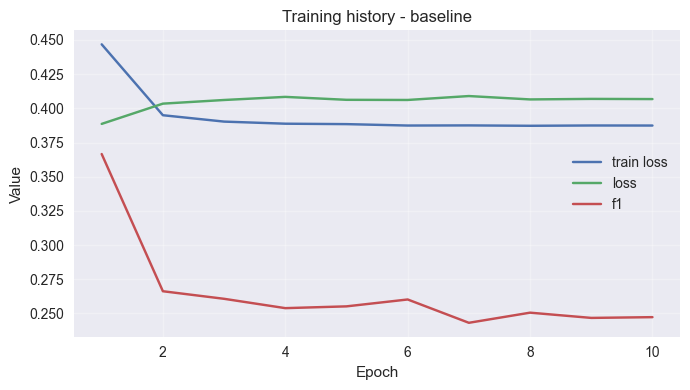

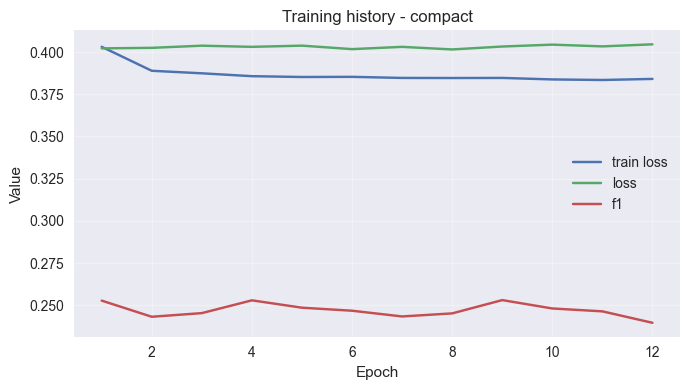

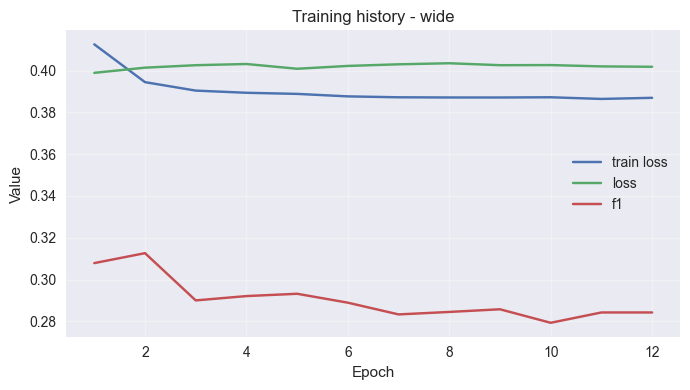

In [16]:
# Plot training history for each experiment (train loss, val loss, F1 across epochs)
history_metrics = ["train_loss", "loss", "f1"]

for result in experiment_results:
    history_df = pd.DataFrame(result["history"])  # convert per-epoch metrics to DataFrame
    plt.figure(figsize=(7, 4))

    # Plot selected metrics if present
    for metric in history_metrics:
        if metric in history_df.columns:
            plt.plot(history_df["epoch"], history_df[metric], label=metric.replace("_", " "))

    plt.title(f"Training history - {result['name']}")  # experiment name
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Test evaluation
Now we pick the best model from experiments (based on F1 score), evaluate the model and save the metrics, create classification report, confusion matrix and log it to Wandb 

Test metrics with tuned threshold:
  loss: 0.4024
  roc_auc: 0.6921
  pr_auc: 0.8346
  accuracy: 0.7292
  precision: 0.7301
  recall: 0.9844
  f1: 0.8384
  recall_at_70_precision: 1.0000
Classification report:
              precision    recall  f1-score   support

         0.0     0.7061    0.0932    0.1647     31470
         1.0     0.7301    0.9844    0.8384     78396

    accuracy                         0.7292    109866
   macro avg     0.7181    0.5388    0.5015    109866
weighted avg     0.7232    0.7292    0.6454    109866

Confusion matrix:


,Pred 0,Pred 1
Actual 0,2934,28536
Actual 1,1221,77175


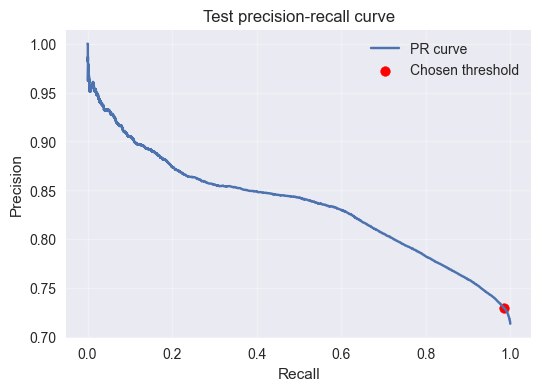

In [ ]:
# Select best experiment by highest validation F1
best_experiment = max(experiment_results, key=lambda item: item["val_metrics"]["f1"])
best_cfg = best_experiment["config"]           # best hyperparameters
best_threshold = best_experiment["threshold"]  # tuned decision threshold (from val set)

# Recreate the best model architecture and load its saved weights
best_model = CovidMLP(len(feature_cols), best_cfg["hidden_layers"], best_cfg["dropout"]).to(device)
best_model.load_state_dict(best_experiment["state_dict"])

# Evaluate on the held-out test set
test_metrics_raw, test_probs, test_labels = evaluate_model(best_model, test_loader)

# Recompute metrics with the tuned threshold (keep ROC AUC & loss from raw eval)
test_metrics = metrics_from_probs(test_probs, test_labels, threshold=best_threshold)
test_metrics["roc_auc"] = test_metrics_raw["roc_auc"]
test_metrics["loss"] = test_metrics_raw["loss"]

# Pretty-print main test metrics
print("Test metrics with tuned threshold:")
for key in ["loss", "roc_auc", "pr_auc", "accuracy", "precision", "recall", "f1", "recall_at_70_precision"]:
    print(f"  {key}: {test_metrics[key]:.4f}")

# Derive hard predictions using tuned threshold, then print a detailed classification report
binary_preds = (test_probs >= best_threshold).astype(int)
print("Classification report:")
print(classification_report(test_labels, binary_preds, digits=4, zero_division=0))

# Confusion matrix (as a DataFrame for nicer display)
cm = confusion_matrix(test_labels, binary_preds)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion matrix:")
display(cm_df)

# Log confusion matrix to Weights & Biases for the best config
if wandb_logs:
    wandb_run = wandb.init(project="covid-19", config=best_cfg, reinit=True)  # new run for test artifacts
    wandb_run.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=binary_preds.tolist(),
            y_true=test_labels.tolist(),
            title="Confusion Matrix of best Model"
        )
    })
    wandb_run.finish()

# Plot Precision-Recall curve with the chosen operating point highlighted
precisions, recalls, _ = precision_recall_curve(test_labels, test_probs)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(test_metrics["recall"], test_metrics["precision"], color="red", label="Chosen threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test precision-recall curve")
plt.grid(alpha=0.3)
plt.legend()
plt.show()